# Portfolio Management for retail Investors

During the summer, I had the opportunity to work at an Asset Management Firm in Greece. I was assigned to the portfolio management/ Investment department where we advised wealthy investors on how to allocate their assets in an optimal way in order to achieve greater diversification and at the same time maximize returns. The purpose of this project is to create a model, using Machine Learning algorithms, that predicts future annual returns and future annual volatility for a given number of stocks. After doing that, we will create an optimal portfolio depending on the risk aversion of the investor. The project is divided into three parts. The first part proves some general assumptions about the stock market, such as the fact that stock market returns follow a normal distribution and that an Exponential Moving Average can be used as a proxy to identify market trends. The second part is devoted in creating the data frames of the stocks that we will analyze and constructing the model that predicts future annual returns and future annual volatility. Finally, the last part of the project is to calculate the optimal portfolio depending on the risk aversion of the investor.

## Outline

- [Portfolio Management for retail Investors](#Portfolio-Management-for-retail-Investors)  
  - [General Observations about asset returns](#General-Observations-about-asset-returns)  
  - [Model](#Model)  
  - [Optimal Portfolio](#Optimal-Portfolio)  

In [1]:
import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mplc
import matplotlib.patches as patches
import seaborn as sns
import yfinance as yf
from datetime import datetime
from pandas_datareader import data as pdr
import plotly.offline as py
import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots
py.init_notebook_mode(connected=True)
from plotly import tools
import plotly.figure_factory as ff

## General Observations about asset returns

We start by selecting a basket of stocks and bond ETFs; I mainly focus on technology companies since they yield higher returns compared to other sectors. Yet, since this model can be easily customized to anyone's need, so you can pick your own basket. I also choose four of the largest bond ETFs. They will serve as a mechanism to achieve greater diversification of our optimal portfolio. SPY is chosen as a benchmark for stocks and AGG (largest bond ETF) as a benchmark for bond ETFs.

In [3]:
stocks = ["AMZN" , "AAPL" , "GOOGL" , "FB" , "WMT", "MSFT" , "SPY"]
bonds = ["BND" , "VCIT" , "VCSH" , "AGG"]

# Dataframe for stocks
df_stocks = pdr.get_data_yahoo(stocks,
                          start='2013-01-01',
                          end=datetime.today().strftime('%Y-%m-%d'),
                          )["Adj Close"].round(3)

# Dataframe for bond ETFs
df_bonds = pdr.get_data_yahoo(bonds,
                          start='2013-01-01',
                          end=datetime.today().strftime('%Y-%m-%d'),
                          )["Adj Close"].round(3)

#20 day Exponential Moving Average
ema_20_stocks = df_stocks.ewm(span=20, adjust=False).mean()

ema_20_bonds = df_bonds.ewm(span=20, adjust=False).mean()

#100 day Exponential Moving Average

ema_100_stocks = df_stocks.ewm(span=100, adjust=False).mean()

ema_100_bonds = df_bonds.ewm(span=100, adjust=False).mean()


# Annual stock returns
annualized_returns_stocks = df_stocks.pct_change(periods = 253)


# Annual bond returns
annualized_returns_bonds = df_bonds.pct_change(periods = 253)

# Annual bond volatility 
annualized_volatility_bonds = pd.DataFrame(df_bonds.pct_change(periods = 253).iloc[i-253:i].std() 
                                          for i in range(len(df_bonds.index)))

#We use 253 because on average there are 253 trading days in a year

In [4]:
df_bonds.tail()

Symbols        BND    VCIT    VCSH      AGG
Date                                       
2020-11-30  88.347  96.991  83.041  118.214
2020-12-01  88.080  96.720  82.990  117.840
2020-12-02  87.930  96.700  82.990  117.710
2020-12-03  88.100  96.910  83.030  117.910
2020-12-04  87.870  96.690  82.990  117.590

In [5]:
df_stocks.tail()

Symbols        AMZN    AAPL    GOOGL      FB     WMT    MSFT     SPY
Date                                                                
2020-11-30  3168.04  119.05  1754.40  276.97  152.79  214.07  362.06
2020-12-01  3220.08  122.72  1795.36  286.55  152.64  216.21  366.02
2020-12-02  3203.53  123.08  1824.97  287.52  150.52  215.37  366.79
2020-12-03  3186.73  122.94  1821.84  281.85  149.30  214.24  366.69
2020-12-04  3162.58  122.25  1823.76  279.70  148.91  214.36  369.85

Constructing a portfolio management model that gives reliable predictions requires to firstly lay out some key assumptions about financial markets; namely that Stock market returns tend to follow a normal distribution and also that the movement of a stock price is not entirely random. Momentum plays a key role in identifying a trend and approximating future performance. The following figures prove the two assumptions that we just introduced. 

In [6]:
group_labels_stocks = ['Weekly Returns AMZN', 'Weekly Returns AAPL' , 'Weekly Returns GOOGL', 'Weekly Returns FB',
                'Weekly Returns TSLA', 'Weekly Returns WMT','Weekly Returns MSFT', 'Weekly Returns SPY' ]

group_labels_bonds = ['Monthly Returns BND', 'Monthly Returns VCIT' , 'Monthly Returns VSCH','Monthly Returns AGG']

colors_stocks = ['blue', 'green' , 'red' , 'pink' , 'orange' , 'yellow' , 'purple' , 'deepskyblue']


colors_bonds = ['blue', 'red' , 'lime' , 'purple']

fig1 = ff.create_distplot([annualized_returns_stocks[c].dropna() for c in annualized_returns_stocks.columns],
                         annualized_returns_stocks.columns , group_labels_stocks, 
                         curve_type='normal', colors=colors_stocks , show_hist=False )
fig1.update_layout(dict(title_text='Stock Annualized Returns Distribution' , xaxis_title = "Annualized Stock Returns", 
                        yaxis_title = "Frequency"))



fig2 = ff.create_distplot([annualized_returns_bonds[i].dropna() for i in annualized_returns_bonds.columns],
                         annualized_returns_bonds.columns , group_labels_bonds, 
                         curve_type='normal', colors=colors_bonds , show_hist=False)
fig2.update_layout(dict(title_text='Bond ETFs Annualized Returns Distribution', xaxis_title = "Annualized Bond ETF Returns", 
                        yaxis_title = "Frequency"))


py.iplot(fig1)
py.iplot(fig2)

The distribution plots are in congruence with the assumption that in general asset annual returns follow a normal distribution. Both stock and bond ETFs annual returns have the majority of realizations located around the mean. Also, stock returns have a much higher variance and standard deviation than bond ETF returns, which is the anticipated outcome since stocks are riskier assets than bond ETFs.

In [10]:
trace0 = go.Scatter(x=df_stocks.reset_index()["Date"], 
                    y=df_stocks["AMZN"], name='AMZN', line=dict(color='deepskyblue'))
trace1 = go.Scatter(x=df_stocks.reset_index()["Date"], 
                    y=df_stocks["GOOGL"], name='GOOGL', line=dict(color='red'))

trace2 = go.Scatter(x=ema_100_stocks.reset_index()["Date"], 
                    y=ema_100_stocks["AMZN"], name='EMA100_AMZN', line=dict(color='blue'))
trace3 = go.Scatter(x=ema_100_stocks.reset_index()["Date"], 
                    y=ema_100_stocks["GOOGL"], name='EMA100_GOOGL', line=dict(color='orange'))


data1 = [trace0, trace1, trace2, trace3]
layout1 = dict(title_text='Stock Price and Exponential Moving Average',
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1, label='1m', step='month', stepmode='backward'),
                dict(count=6, label='6m', step='month', stepmode='backward'),
                dict(count=12, label='1y', step='month',stepmode='backward'),
                dict(count=36, label='3y', step='month', stepmode='backward')
            ])
        ),
        rangeslider=dict(
            visible = True
        ), type='date'
    )
)

fig = dict(data=data1, layout=layout1)
py.iplot(fig)


In [11]:
trace0 = go.Scatter(x=df_stocks.reset_index()["Date"], 
                    y=df_stocks["AAPL"], name='AAPL', line=dict(color='black'))
trace1 = go.Scatter(x=df_stocks.reset_index()["Date"], 
                    y=df_stocks["FB"], name='FB', line=dict(color='red'))
trace2 = go.Scatter(x=df_stocks.reset_index()["Date"], 
                    y=df_stocks["MSFT"], name='MSFT', line=dict(color='yellow')) 
trace3 = go.Scatter(x=df_stocks.reset_index()["Date"], 
                    y=df_stocks["WMT"], name='WMT', line=dict(color='blue'))
trace4 = go.Scatter(x=df_stocks.reset_index()["Date"], 
                    y=df_stocks["SPY"], name='SPY', line=dict(color='green'))

trace5 = go.Scatter(x=ema_100_stocks.reset_index()["Date"], 
                    y=ema_100_stocks["AAPL"], name='EMA100_AAPL', line=dict(color='grey'))
trace6 = go.Scatter(x=ema_100_stocks.reset_index()["Date"], 
                    y=ema_100_stocks["FB"], name='EMA100_FB', line=dict(color='coral'))
trace7 = go.Scatter(x=ema_100_stocks.reset_index()["Date"], 
                    y=ema_100_stocks["MSFT"], name='EMA100_MSFT', line=dict(color='goldenrod')) 
trace8 = go.Scatter(x=ema_100_stocks.reset_index()["Date"], 
                    y=ema_100_stocks["WMT"], name='EMA100_WMT', line=dict(color='deepskyblue'))
trace9 = go.Scatter(x=ema_100_stocks.reset_index()["Date"], 
                    y=ema_100_stocks["SPY"], name='EMA100_SPY', line=dict(color='lime'))



data2 = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7, trace8, trace9]
layout2 = dict(title_text='Stock Price and Exponential Moving Average',
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1, label='1m', step='month', stepmode='backward'),
                dict(count=6, label='6m', step='month', stepmode='backward'),
                dict(count=12, label='1y', step='month',stepmode='backward'),
                dict(count=36, label='3y', step='month', stepmode='backward')
            ])
        ),
        rangeslider=dict(
            visible = True
        ), type='date'
    )
)

fig = dict(data=data2, layout=layout2)
py.iplot(fig)


In [12]:
trace0 = go.Scatter(x=df_bonds.reset_index()["Date"], 
                    y=df_bonds["BND"], name='BND', line=dict(color='black'))
trace1 = go.Scatter(x=df_bonds.reset_index()["Date"], 
                    y=df_bonds["VCIT"], name='VCIT', line=dict(color='red'))
trace2 = go.Scatter(x=df_bonds.reset_index()["Date"], 
                    y=df_bonds["VCSH"], name='VCSH', line=dict(color='yellow'))
trace3 = go.Scatter(x=df_bonds.reset_index()["Date"], 
                    y=df_bonds["AGG"], name='AGG', line=dict(color='blue'))

trace4 = go.Scatter(x=ema_100_bonds.reset_index()["Date"], 
                    y=ema_100_bonds["BND"], name='EMA100_BND', line=dict(color='grey'))
trace5 = go.Scatter(x=ema_100_bonds.reset_index()["Date"], 
                    y=ema_100_bonds["VCIT"], name='EMA100_VCIT', line=dict(color='coral'))
trace6 = go.Scatter(x=ema_100_bonds.reset_index()["Date"], 
                    y=ema_100_bonds["VCSH"], name='EMA100_VCSH', line=dict(color='goldenrod'))
trace7 = go.Scatter(x=ema_100_bonds.reset_index()["Date"], 
                    y=ema_100_bonds["AGG"], name='EMA100_AGG', line=dict(color='deepskyblue'))



data3 = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout3 = dict(title_text='Bond ETF Price and Exponential Moving Average ',
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1, label='1m', step='month', stepmode='backward'),
                dict(count=6, label='6m', step='month', stepmode='backward'),
                dict(count=12, label='1y', step='month',stepmode='backward'),
                dict(count=36, label='3y', step='month', stepmode='backward')
            ])
        ),
        rangeslider=dict(
            visible = True
        ), type='date'
    )
)

fig = dict(data=data3, layout=layout3)
py.iplot(fig)


From the three graphs above, we can conclude that the EMA_100 shows a clear trend of stock prices which can be used in relation to annualized stock returns and annualized volatility.

## Model

Unfortunately, being a retail investor, means we do not have access to a Bloomberg or Reuters terminal. Hence, we have to overcome certain constraints in order to create the final form of our data frames that will be used to make predictions about future stock returns. Firstly, it's easy to find daily stock prices, many websites such as Yahoo Finance, Macrotrends and MarketWatch have daily price data. However other fundamental indicators such as (Current Ratio, ROA, ROE, ROI, EPS, P/E_ratio, Market_Cap , EV/EBITDA etc.) are only found on a quarterly basis. To overcome this problem, we will create 3 data frames; one that has the daily data and the other two that have the quarterly data. We will then merge the 3 data frames, fill in all the missing values between quarters by the value of the previous quarter, and finally since between quarters the fundamental indicators do not change much but rather have small daily fluctuations, we will take a random point from a uniform distribution with mean 1 and a very small standard deviation to approximate the daily movement of fundamental indicators and create a data frame that updates on a daily basis.

In [13]:
import yahoo_fin.stock_info as si
import finpie
from sklearn import (
    linear_model, metrics, neural_network, pipeline,
    model_selection, tree)
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

We will use two packages to collect the stock data: yahoo_fin.stock_info for the daily stock price data and finpie for the fundamentals which are on a quarterly basis.

Another problem that we have to overcome, is that the oldest data for fundamental indicators that we can find is from 2005. However, Facebook was not a public company then. Therefore, we will create a function which produces the final data frames for Amazon , Apple , Google, Microsoft and Walmart, and separately do the same thing for Facebook.


### Facebook Dataframe

In [14]:
fb_data = si.get_data('FB', start_date = '2012-12-31', 
                        end_date = None, index_as_date = True).reset_index()[["index" , "adjclose" , "volume"]]
# There are 253 trading days on average, therefore we use periods = 253.
fb_data["annualized_stock_return"] = fb_data["adjclose"].pct_change(periods = 253)
fb_data["annualized_volume_return"] = fb_data["volume"].pct_change(periods = 253)
fb_data["100_day_ema"] = fb_data["adjclose"].ewm(span=100, adjust=False).mean()

fd = finpie.Fundamentals('FB', freq = 'Q')
fb_fundementals = fd.ratios().iloc[13:].reset_index()[["date" , "current_ratio" , "roe__return_on_equity" 
                                , "book_value_per_share" , "free_cash_flow_per_share"]]
fb_income_statement = fd.income_statement().iloc[13:].reset_index()[["date", "revenue" , "net_income" , "ebitda" 
             , "shares_outstanding" ,  "eps__earnings_per_share"]].rename(columns={"date": "data2"})

df_fb1 = pd.merge( fb_data, fb_fundementals, left_on='index' 
                   ,right_on='date' ,how='left').drop(columns = ["date"])
df_fb = pd.merge( df_fb1, fb_income_statement, left_on='index' 
                   ,right_on='data2' ,how='left').drop(columns = ["data2"]).fillna(method='ffill')
fb_adj = df_fb[["current_ratio" , "roe__return_on_equity" , "book_value_per_share", "free_cash_flow_per_share"
                    ,"revenue" ,"net_income" ,"ebitda" ,"shares_outstanding" ,"eps__earnings_per_share"]]
df_fb[["current_ratio" , "roe__return_on_equity" , "book_value_per_share", "free_cash_flow_per_share"
        ,"revenue" ,"net_income" ,"ebitda" ,"shares_outstanding" ,"eps__earnings_per_share"]] = df_fb[["current_ratio" 
        , "roe__return_on_equity" , "book_value_per_share", "free_cash_flow_per_share","revenue" ,"net_income" ,"ebitda" 
        ,"shares_outstanding" ,"eps__earnings_per_share"]].mul(np.random.uniform(low=0.95, high=1.05, size= fb_adj.shape))
df_fb["P/E_ratio"] = df_fb["adjclose"]/df_fb["eps__earnings_per_share"] 
df_fb["Market_Cap"] = df_fb["adjclose"]*df_fb["shares_outstanding"]
df_fb["EV/EBITDA"] = df_fb["Market_Cap"]/df_fb["ebitda"]
df_fb["Annualized_Volatility"] = [df_fb["annualized_stock_return"].iloc[i-253:i].std() for i in range(len(df_fb.index))]

In [15]:
df_fb.tail()

index    adjclose    volume  annualized_stock_return  \
1993 2020-11-30  276.970001  16693300                 0.371139   
1994 2020-12-01  286.549988  20777900                 0.421097   
1995 2020-12-02  287.519989  17361600                 0.439760   
1996 2020-12-03  281.850006  12921700                 0.417614   
1997 2020-12-04  279.700012  10846900                 0.407579   

      annualized_volume_return  100_day_ema  current_ratio  \
1993                  0.310656   262.039156       5.504147   
1994                  1.602051   262.524519       5.731097   
1995                  0.509258   263.019479       5.709178   
1996                  0.114391   263.392361       5.773635   
1997                  0.282700   263.715284       5.629387   

      roe__return_on_equity  book_value_per_share  free_cash_flow_per_share  \
1993               6.736971             41.467047                  2.102797   
1994               6.453502             39.352228                  2.041076   
1995               6.390803             40.180512                  2.140396   
1996               6.588690             41.534584                  2.191657   
1997               6.516154             43.268550                  2.185728   

           revenue   net_income        ebitda  shares_outstanding  \
1993  21339.269408  7637.008238   9536.948325         2814.862342   
1994  22206.657149  7736.308245  10083.452223         2781.930456   
1995  20993.911637  7821.832415   9858.742293         2999.489701   
1996  21120.273218  7769.483746   9470.362929         2782.973482   
1997  21267.149754  7718.308400   9501.305572         2916.043037   

      eps__earnings_per_share   P/E_ratio     Market_Cap  EV/EBITDA  \
1993                 2.691349  102.911201  779632.426385  81.748626   
1994                 2.694633  106.341024  797162.138213  79.056470   
1995                 2.812094  102.244106  862413.245986  87.477005   
1996                 2.837572   99.327866  784381.093007  82.824819   
1997                 2.815897   99.328904  815617.273056  85.842653   

      Annualized_Volatility  
1993               0.193648  
1994               0.193370  
1995               0.193139  
1996               0.193077  
1997               0.193036

### Microsoft , Amazon , Google,  Apple, Walmart Dataframes

In [16]:
def df(stock):
    data = si.get_data(stock, start_date = '2005-3-31', 
                        end_date = None, index_as_date = True).reset_index()[["index" , "adjclose" , "volume"]]
    # There are 253 trading days on average, therefore we use periods = 253.
    data["annualized_stock_return"] = data["adjclose"].pct_change(periods = 253)
    data["annualized_volume_return"] = data["volume"].pct_change(periods = 253)
    data["100_day_ema"] = data["adjclose"].ewm(span=100, adjust=False).mean()
    
    
    fd = finpie.Fundamentals(stock, freq = 'Q')
    fundementals = fd.ratios().reset_index()[["date" , "current_ratio" , "roe__return_on_equity" 
                                                      , "book_value_per_share" , "free_cash_flow_per_share"]]
    income_statement = fd.income_statement().reset_index()[["date", "revenue" , "net_income" , "ebitda" 
                            , "shares_outstanding" ,  "eps__earnings_per_share"]].rename(columns={"date": "date2"})

    df_1 = pd.merge(data, fundementals, left_on='index' 
                   ,right_on='date' ,how='left').drop(columns = ["date"])
    df = pd.merge( df_1, income_statement, left_on='index' 
                   ,right_on='date2' ,how='left').drop(columns = ["date2"]).fillna(method='ffill')
    adj = df[["current_ratio" , "roe__return_on_equity" , "book_value_per_share", "free_cash_flow_per_share"
                    ,"revenue" ,"net_income" ,"ebitda" ,"shares_outstanding" ,"eps__earnings_per_share"]]
    df[["current_ratio" , "roe__return_on_equity" , "book_value_per_share", "free_cash_flow_per_share"
        ,"revenue" ,"net_income" ,"ebitda" ,"shares_outstanding" ,"eps__earnings_per_share"]] = df[["current_ratio" 
        , "roe__return_on_equity" , "book_value_per_share", "free_cash_flow_per_share","revenue" ,"net_income" ,"ebitda" 
        ,"shares_outstanding" ,"eps__earnings_per_share"]].mul(np.random.uniform(low=0.95, high=1.05, size= adj.shape))
    df["P/E_ratio"] = df["adjclose"]/df["eps__earnings_per_share"] 
    df["Market_Cap"] = df["adjclose"]*df["shares_outstanding"]
    df["EV/EBITDA"] = df["Market_Cap"]/df["ebitda"]
    df["Annualized_Volatility"] = [df["annualized_stock_return"].iloc[i-253:i].std() for i in range(len(df.index))]
    return df

In [17]:
df_msft = df("MSFT")

In [18]:
df_aapl = df("AAPL")

In [19]:
df_wmt = df("WMT")

In [20]:
df_amzn = df("AMZN")

In [21]:
df_googl = df("GOOGL")

In [22]:
df_aapl.tail()

index    adjclose     volume  annualized_stock_return  \
3945 2020-11-30  119.050003  169410200                 0.807964   
3946 2020-12-01  122.720001  128166800                 0.867813   
3947 2020-12-02  123.080002   89004200                 0.895205   
3948 2020-12-03  122.940002   78967600                 0.927415   
3949 2020-12-04  122.250000   78133200                 0.899829   

      annualized_volume_return  100_day_ema  current_ratio  \
3945                  1.596898   110.135591       1.332837   
3946                  1.749322   110.384788       1.401127   
3947                 -0.058029   110.636178       1.297262   
3948                 -0.309907   110.879818       1.380474   
3949                  0.163015   111.104970       1.380485   

      roe__return_on_equity  book_value_per_share  free_cash_flow_per_share  \
3945              18.747271              3.699425                  1.063006   
3946              18.957798              3.846178                  1.015317   
3947              18.678335              3.926590                  1.014663   
3948              18.513005              3.722411                  1.034775   
3949              19.258115              3.733099                  1.080056   

           revenue    net_income        ebitda  shares_outstanding  \
3945  67070.698843  12093.375298  17986.699373        17057.248960   
3946  64120.491754  12720.908265  17628.362227        18167.948225   
3947  63369.314412  13279.966579  16706.305626        18158.009155   
3948  64438.919231  12978.772760  18293.309217        16885.944654   
3949  62841.126427  12325.635156  17123.060228        17532.994609   

      eps__earnings_per_share   P/E_ratio    Market_Cap   EV/EBITDA  \
3945                 0.718378  165.720538  2.030666e+06  112.898175   
3946                 0.778560  157.624361  2.229571e+06  126.476334   
3947                 0.730749  168.429866  2.234888e+06  133.775106   
3948                 0.737647  166.665006  2.075958e+06  113.481823   
3949                 0.735921  166.118284  2.143409e+06  125.176724   

      Annualized_Volatility  
3945               0.291488  
3946               0.290932  
3947               0.290364  
3948               0.289465  
3949               0.288502

We create a function that gives us the accuracy of our model depending on the regression algorithm we used and all the predictions for the future annual returns. We apply this function to every stock.  

In [23]:
def stock_predictor(df, model, stock , mod_name):
    
    #make a copy of the initial dataframe
    df_stock = df.copy()
    
    #separate the line that we are going to predict (final line of the dataframe)
    df_tomorrow = df.iloc[-1:, :].copy()
    
    
    df_stock['Next_ann_stock_return'] = df_stock['annualized_stock_return'].shift(-1)
    
    
    df_stock.dropna(inplace=True)
    
    
    X_variables = ["adjclose", "volume", "annualized_volume_return" ,"100_day_ema", "current_ratio", "roe__return_on_equity",
               "book_value_per_share", "free_cash_flow_per_share", "revenue", "net_income", "ebitda",
               "shares_outstanding", "eps__earnings_per_share", "P/E_ratio", "Market_Cap", "EV/EBITDA"]
    
    #Start Building the model.
    y = df_stock['Next_ann_stock_return']
    
    X = df_stock[X_variables]

    #Split the data 70% train , 30% validation.
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=100, test_size=.3)
    
    model.fit(X_train, y_train)
    
    return dict(
        company_name = stock,
        estimator = mod_name,
        mse_train = mean_squared_error(y_train, model.predict(X_train)).round(4),
        mse_test =  mean_squared_error(y_test, model.predict(X_test)).round(4) , 
        score_train = model.score(X_train , y_train).round(4),
        score_test = model.score(X_test , y_test).round(4),
        next_annual_return_prediction = model.predict(df_tomorrow[X_variables]).round(4).item()
    )
 

We do the same thing as the above function but now for the future annual volatility

In [24]:
def volatility_predictor(df, model, stock , mod_name):
    
    #make a copy of the initial dataframe
    df_stock = df.copy()
    
    #separate the line that we are going to predict (final line of the dataframe)
    df_tomorrow = df.iloc[-1:, :].copy()
    
    
    df_stock['Next_ann_volatility'] = df_stock['Annualized_Volatility'].shift(-1)
    
    
    df_stock.dropna(inplace=True)
    
    
    X_variables = ["adjclose", "volume", "annualized_volume_return" ,"100_day_ema", "current_ratio", "roe__return_on_equity",
               "book_value_per_share", "free_cash_flow_per_share", "revenue", "net_income", "ebitda",
               "shares_outstanding", "eps__earnings_per_share", "P/E_ratio", "Market_Cap", "EV/EBITDA"]
    
    #Start Building the model.
    y = df_stock['Next_ann_volatility']
    
    X = df_stock[X_variables]

    #Split the data 70% train , 30% validation.
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=100, test_size=.3)
    
    model.fit(X_train, y_train)
    
    return dict(
        company_name = stock,
        estimator = mod_name,
        mse_train = mean_squared_error(y_train, model.predict(X_train)).round(4),
        mse_test =  mean_squared_error(y_test, model.predict(X_test)).round(4) , 
        score_train = model.score(X_train , y_train).round(4),
        score_test = model.score(X_test , y_test).round(4),
        next_annual_volatility_prediction = model.predict(df_tomorrow[X_variables]).round(4).item()
    )
   

The function below returns a nested list with all the accuracy scores for all the regression algorithms we used above.

In [25]:
def get_scores(df):
    
    # this function returns the model accuracy scores for all the three models that we used (both of the annualized returns
    #and for the annualized volatility).
    
    df_s = df.copy()
    
    df_s['Next_ann_stock_return'] = df_s['annualized_stock_return'].shift(-1)
    df_s['Next_ann_volatility'] = df_s['Annualized_Volatility'].shift(-1)
    
    df_s.dropna(inplace=True)
    
    X_variables1 = ["adjclose", "volume", "annualized_volume_return" ,"100_day_ema", "current_ratio", "roe__return_on_equity",
               "book_value_per_share", "free_cash_flow_per_share", "revenue", "net_income", "ebitda",
               "shares_outstanding", "eps__earnings_per_share", "P/E_ratio", "Market_Cap", "EV/EBITDA"]
    X_variables2 = ["adjclose", "volume", "annualized_volume_return" ,"100_day_ema", "current_ratio", "roe__return_on_equity",
               "book_value_per_share", "free_cash_flow_per_share", "revenue", "net_income", "ebitda",
               "shares_outstanding", "eps__earnings_per_share", "P/E_ratio", "Market_Cap", "EV/EBITDA"]
    
    y1 = df_s['Next_ann_stock_return']
    y2 = df_s['Next_ann_volatility']
    X1 = df_s[X_variables1]
    X2 = df_s[X_variables2]
    
    
    
    model_1 = linear_model.LinearRegression()
    model_2 = linear_model.Lasso(max_iter = 100000)
    model_3 = RandomForestRegressor()
    model_4 = linear_model.LinearRegression()
    model_5 = linear_model.Lasso(max_iter = 100000)
    model_6 = RandomForestRegressor()
    

    X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, random_state=100, test_size=.3)
    X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, random_state=100, test_size=.3)
    
    
    model_1.fit(X1_train, y1_train)
    model_2.fit(X1_train, y1_train)
    model_3.fit(X1_train, y1_train)
    model_4.fit(X2_train, y2_train)
    model_5.fit(X2_train, y2_train)
    model_6.fit(X2_train, y2_train)
    
    return   [ [ model_1.score(X1_train , y1_train).round(4),
                 model_2.score(X1_train , y1_train).round(4),
                 model_3.score(X1_train , y1_train).round(4),
               ] ,
              [  model_1.score(X1_test , y1_test).round(4),
                 model_2.score(X1_test , y1_test).round(4),
                 model_3.score(X1_test , y1_test).round(4),
             
              ] , [ model_4.score(X2_train , y2_train).round(4),
                    model_5.score(X2_train , y2_train).round(4),
                    model_6.score(X2_train , y2_train).round(4),
               ] ,
              [  model_4.score(X2_test , y2_test).round(4),
                 model_5.score(X2_test , y2_test).round(4),
                 model_6.score(X2_test , y2_test).round(4),
             
              ]
             ]

Finally, we create a function that returns a barplot with all the accuracy scores of all regression methods used.

In [82]:
def get_model_accuracy_results(df, color_1 , color_2 , color_3, color_4, title ):
    data_scores = {'Train_Scores_Annualized_Returns': get_scores(df)[0] ,
                    'Test_Scores_Annualized_Returns': get_scores(df)[1] ,
                    'Train_Scores_Annualized_Volatility': get_scores(df)[2] ,
                    'Test_Scores_Annualized_Volatility': get_scores(df)[3] ,
       'Model' : ['Linear Regression','Lasso Regression','Random Forest'] }
    
    scores = pd.DataFrame(data_scores, columns = ['Model','Train_Scores_Annualized_Returns','Test_Scores_Annualized_Returns',
                                               'Train_Scores_Annualized_Volatility', 'Test_Scores_Annualized_Volatility' ],)
    
    scores_dataframe = scores.set_index('Model')
    
    fig, ax = plt.subplots(figsize=(12,8))
    scores_dataframe.plot(kind="bar", ax=ax , title = title , color = [color_1 , color_2 , color_3, color_4]) 
    plt.rcParams.update({'font.size': 15})
    plt.xticks(rotation=360)
    
    #fig.tight_layout()
    
    return fig


### Apple Predictions

#### Annualized return Prediction

In [83]:
Apple_returns = [stock_predictor(df_aapl, linear_model.LinearRegression(), "Apple" , "Linear Regression"),
             stock_predictor(df_aapl, linear_model.Lasso(max_iter = 100000), "Apple" , "Lasso Regression"),
             stock_predictor(df_aapl, RandomForestRegressor(), "Apple" , "Random Forest")]

print(*Apple_returns, sep='\n')

{'company_name': 'Apple', 'estimator': 'Linear Regression', 'mse_train': 0.0831, 'mse_test': 0.0929, 'score_train': 0.5107, 'score_test': 0.4978, 'next_annual_return_prediction': 1.0512}
{'company_name': 'Apple', 'estimator': 'Lasso Regression', 'mse_train': 0.1006, 'mse_test': 0.1138, 'score_train': 0.4075, 'score_test': 0.3849, 'next_annual_return_prediction': 1.2833}
{'company_name': 'Apple', 'estimator': 'Random Forest', 'mse_train': 0.0008, 'mse_test': 0.0056, 'score_train': 0.9954, 'score_test': 0.9698, 'next_annual_return_prediction': 0.8569}


#### Annualized Volatility Prediction

In [84]:
Apple_volatility = [volatility_predictor(df_aapl, linear_model.LinearRegression(), "Apple" , "Linear Regression"),
             volatility_predictor(df_aapl, linear_model.Lasso(max_iter = 100000), "Apple" , "Lasso Regression"),
             volatility_predictor(df_aapl, RandomForestRegressor(), "Apple" , "Random Forest")]

print(*Apple_volatility, sep='\n')

{'company_name': 'Apple', 'estimator': 'Linear Regression', 'mse_train': 0.0064, 'mse_test': 0.0071, 'score_train': 0.5732, 'score_test': 0.5802, 'next_annual_volatility_prediction': 0.3218}
{'company_name': 'Apple', 'estimator': 'Lasso Regression', 'mse_train': 0.0125, 'mse_test': 0.0135, 'score_train': 0.1587, 'score_test': 0.194, 'next_annual_volatility_prediction': 0.2487}
{'company_name': 'Apple', 'estimator': 'Random Forest', 'mse_train': 0.0, 'mse_test': 0.0002, 'score_train': 0.9983, 'score_test': 0.9901, 'next_annual_volatility_prediction': 0.2943}


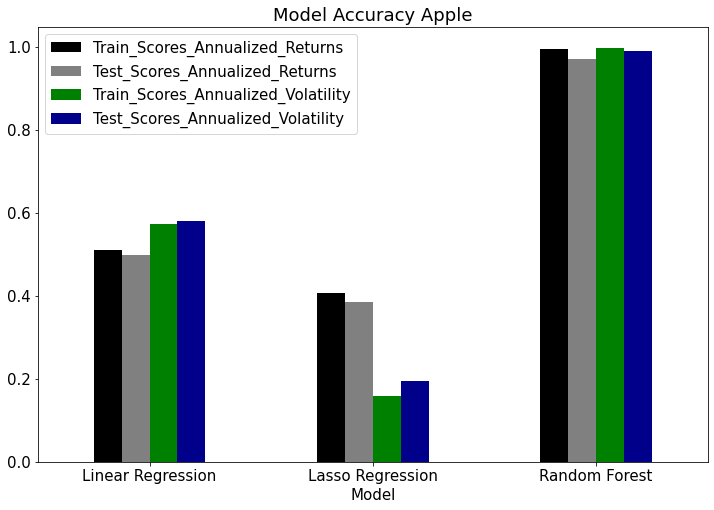

In [85]:
get_model_accuracy_results(df_aapl, "black" , "grey" , "green", "darkblue" , "Model Accuracy Apple");

### Microsoft Inc. Predictions

#### Annualized return Prediction

In [86]:
Microsoft_returns = [stock_predictor(df_msft, linear_model.LinearRegression(), "Microsoft.inc" , "Linear Regression"),
             stock_predictor(df_msft, linear_model.Lasso(), "Microsoft.inc" , "Lasso Regression"),
             stock_predictor(df_msft, RandomForestRegressor(), "Microsoft.inc" , "Random Forest")]

print(*Microsoft_returns, sep='\n')

{'company_name': 'Microsoft.inc', 'estimator': 'Linear Regression', 'mse_train': 0.0215, 'mse_test': 0.0249, 'score_train': 0.5937, 'score_test': 0.5672, 'next_annual_return_prediction': 0.3842}
{'company_name': 'Microsoft.inc', 'estimator': 'Lasso Regression', 'mse_train': 0.031, 'mse_test': 0.0355, 'score_train': 0.4126, 'score_test': 0.3843, 'next_annual_return_prediction': 0.6035}
{'company_name': 'Microsoft.inc', 'estimator': 'Random Forest', 'mse_train': 0.0003, 'mse_test': 0.0026, 'score_train': 0.9939, 'score_test': 0.9556, 'next_annual_return_prediction': 0.4409}


#### Annualized Volatility Prediction

In [87]:
Microsoft_volatility = [volatility_predictor(df_msft, linear_model.LinearRegression(), "Microsoft" , "Linear Regression"),
             volatility_predictor(df_msft, linear_model.Lasso(max_iter = 100000), "Microsoft" , "Lasso Regression"),
             volatility_predictor(df_msft, RandomForestRegressor(), "Microsoft" , "Random Forest")]

print(*Microsoft_volatility, sep='\n')

{'company_name': 'Microsoft', 'estimator': 'Linear Regression', 'mse_train': 0.0029, 'mse_test': 0.0034, 'score_train': 0.3264, 'score_test': 0.3182, 'next_annual_volatility_prediction': 0.1306}
{'company_name': 'Microsoft', 'estimator': 'Lasso Regression', 'mse_train': 0.0035, 'mse_test': 0.004, 'score_train': 0.1832, 'score_test': 0.1913, 'next_annual_volatility_prediction': 0.1258}
{'company_name': 'Microsoft', 'estimator': 'Random Forest', 'mse_train': 0.0, 'mse_test': 0.0, 'score_train': 0.9986, 'score_test': 0.9923, 'next_annual_volatility_prediction': 0.1109}


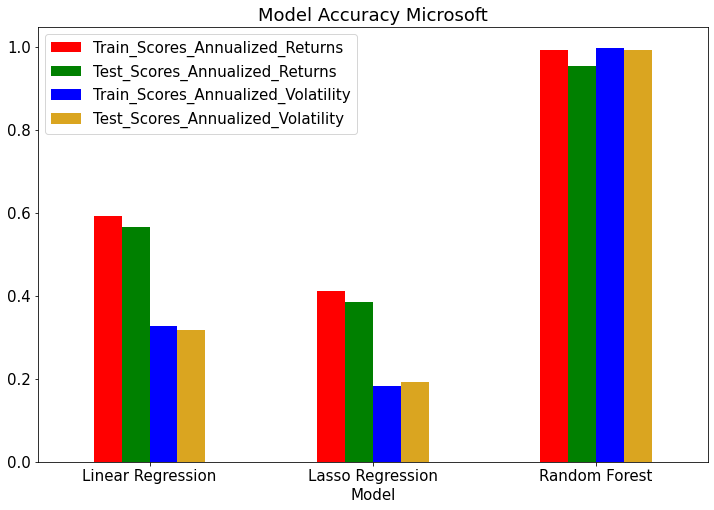

In [88]:
get_model_accuracy_results(df_msft, "red" , "green" , "blue", "goldenrod" , "Model Accuracy Microsoft");

### Walmart Predictions

#### Annualized return Prediction

In [89]:
Walmart_returns = [stock_predictor(df_wmt, linear_model.LinearRegression(), "Walmart" , "Linear Regression"),
             stock_predictor(df_wmt, linear_model.Lasso(), "Walmart" , "Lasso Regression"),
             stock_predictor(df_wmt, RandomForestRegressor(), "Walmart" , "Random Forest")]

print(*Walmart_returns, sep='\n')

{'company_name': 'Walmart', 'estimator': 'Linear Regression', 'mse_train': 0.0103, 'mse_test': 0.0102, 'score_train': 0.5374, 'score_test': 0.5095, 'next_annual_return_prediction': 0.3686}
{'company_name': 'Walmart', 'estimator': 'Lasso Regression', 'mse_train': 0.0162, 'mse_test': 0.0156, 'score_train': 0.2713, 'score_test': 0.2534, 'next_annual_return_prediction': 0.3545}
{'company_name': 'Walmart', 'estimator': 'Random Forest', 'mse_train': 0.0002, 'mse_test': 0.0014, 'score_train': 0.9909, 'score_test': 0.9321, 'next_annual_return_prediction': 0.2836}


#### Annualized Volatility Prediction

In [90]:
Walmart_volatility = [volatility_predictor(df_wmt, linear_model.LinearRegression(), "Walmart" , "Linear Regression"),
             volatility_predictor(df_wmt, linear_model.Lasso(max_iter = 100000), "Walmart" , "Lasso Regression"),
             volatility_predictor(df_wmt, RandomForestRegressor(), "Walmart" , "Random Forest")]

print(*Walmart_volatility, sep='\n')

{'company_name': 'Walmart', 'estimator': 'Linear Regression', 'mse_train': 0.0009, 'mse_test': 0.001, 'score_train': 0.4007, 'score_test': 0.3873, 'next_annual_volatility_prediction': 0.0624}
{'company_name': 'Walmart', 'estimator': 'Lasso Regression', 'mse_train': 0.0012, 'mse_test': 0.0011, 'score_train': 0.2627, 'score_test': 0.2896, 'next_annual_volatility_prediction': 0.0567}
{'company_name': 'Walmart', 'estimator': 'Random Forest', 'mse_train': 0.0, 'mse_test': 0.0, 'score_train': 0.997, 'score_test': 0.9801, 'next_annual_volatility_prediction': 0.0586}


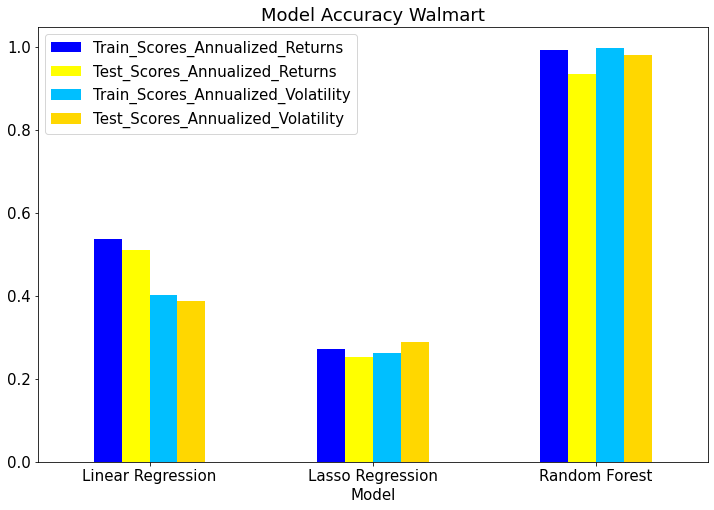

In [91]:
get_model_accuracy_results(df_wmt, "blue" , "yellow" , "deepskyblue", "gold" , "Model Accuracy Walmart");

### Amazon Predictions

#### Annualized return Prediction

In [92]:
Amazon_returns = [stock_predictor(df_amzn, linear_model.LinearRegression(), "Amazon" , "Linear Regression"),
             stock_predictor(df_amzn, linear_model.Lasso(max_iter = 100000), "Amazon" , "Lasso Regression"),
             stock_predictor(df_amzn, RandomForestRegressor(), "Amazon" , "Random Forest")]

print(*Amazon_returns, sep='\n')

{'company_name': 'Amazon', 'estimator': 'Linear Regression', 'mse_train': 0.1366, 'mse_test': 0.1411, 'score_train': 0.3009, 'score_test': 0.2849, 'next_annual_return_prediction': 0.4121}
{'company_name': 'Amazon', 'estimator': 'Lasso Regression', 'mse_train': 0.1514, 'mse_test': 0.1566, 'score_train': 0.2253, 'score_test': 0.2063, 'next_annual_return_prediction': 0.5073}
{'company_name': 'Amazon', 'estimator': 'Random Forest', 'mse_train': 0.001, 'mse_test': 0.0088, 'score_train': 0.9947, 'score_test': 0.9552, 'next_annual_return_prediction': 0.7876}


#### Annualized Volatility Prediction

In [93]:
Amazon_volatility = [volatility_predictor(df_amzn, linear_model.LinearRegression(), "Amazon" , "Linear Regression"),
             volatility_predictor(df_amzn, linear_model.Lasso(max_iter = 100000), "Amazon" , "Lasso Regression"),
             volatility_predictor(df_amzn, RandomForestRegressor(), "Amazon" , "Random Forest")]

print(*Amazon_volatility, sep='\n')

{'company_name': 'Amazon', 'estimator': 'Linear Regression', 'mse_train': 0.0207, 'mse_test': 0.0225, 'score_train': 0.3262, 'score_test': 0.3476, 'next_annual_volatility_prediction': 0.3307}
{'company_name': 'Amazon', 'estimator': 'Lasso Regression', 'mse_train': 0.0233, 'mse_test': 0.025, 'score_train': 0.2405, 'score_test': 0.2738, 'next_annual_volatility_prediction': 0.3379}
{'company_name': 'Amazon', 'estimator': 'Random Forest', 'mse_train': 0.0, 'mse_test': 0.0003, 'score_train': 0.999, 'score_test': 0.9915, 'next_annual_volatility_prediction': 0.2881}


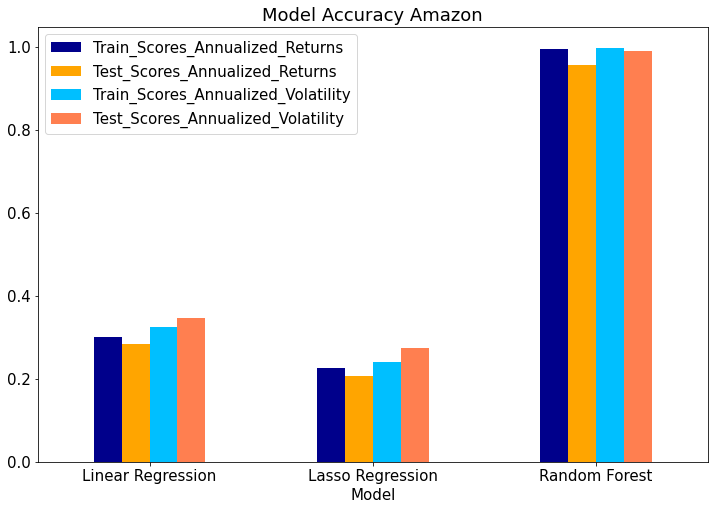

In [94]:
get_model_accuracy_results(df_amzn, "darkblue" , "orange" , "deepskyblue", "coral" , "Model Accuracy Amazon");

### Facebook Predictions

#### Annualized return Prediction

In [95]:
Facebook_returns = [stock_predictor(df_fb, linear_model.LinearRegression(), "Facebook" , "Linear Regression"),
             stock_predictor(df_fb, linear_model.Lasso(max_iter = 100000), "Facebook" , "Lasso Regression"),
             stock_predictor(df_fb, RandomForestRegressor(), "Facebook" , "Random Forest")]

print(*Facebook_returns, sep='\n')

{'company_name': 'Facebook', 'estimator': 'Linear Regression', 'mse_train': 0.048, 'mse_test': 0.0509, 'score_train': 0.6553, 'score_test': 0.6424, 'next_annual_return_prediction': 0.0976}
{'company_name': 'Facebook', 'estimator': 'Lasso Regression', 'mse_train': 0.0713, 'mse_test': 0.0731, 'score_train': 0.4882, 'score_test': 0.4868, 'next_annual_return_prediction': 0.1609}
{'company_name': 'Facebook', 'estimator': 'Random Forest', 'mse_train': 0.0008, 'mse_test': 0.0049, 'score_train': 0.9944, 'score_test': 0.9656, 'next_annual_return_prediction': 0.4013}


#### Annualized Volatility Prediction

In [96]:
Facebook_volatility = [volatility_predictor(df_fb, linear_model.LinearRegression(), "Facebook" , "Linear Regression"),
             volatility_predictor(df_fb, linear_model.Lasso(max_iter = 100000), "Facebook" , "Lasso Regression"),
             volatility_predictor(df_fb, RandomForestRegressor(), "Facebook" , "Random Forest")]

print(*Facebook_volatility, sep='\n')

{'company_name': 'Facebook', 'estimator': 'Linear Regression', 'mse_train': 0.0052, 'mse_test': 0.0052, 'score_train': 0.588, 'score_test': 0.6325, 'next_annual_volatility_prediction': 0.2193}
{'company_name': 'Facebook', 'estimator': 'Lasso Regression', 'mse_train': 0.0064, 'mse_test': 0.0065, 'score_train': 0.4971, 'score_test': 0.5399, 'next_annual_volatility_prediction': 0.1317}
{'company_name': 'Facebook', 'estimator': 'Random Forest', 'mse_train': 0.0, 'mse_test': 0.0001, 'score_train': 0.9983, 'score_test': 0.9907, 'next_annual_volatility_prediction': 0.1911}


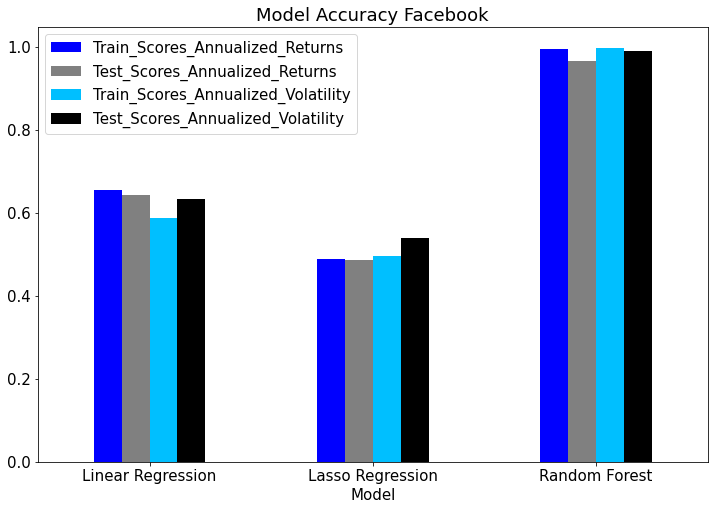

In [97]:
get_model_accuracy_results(df_fb, "blue" , "grey" , "deepskyblue", "black" , "Model Accuracy Facebook");

### Google Predictions

#### Annualized return Prediction

In [98]:
Google_returns = [stock_predictor(df_googl, linear_model.LinearRegression(), "Google" , "Linear Regression"),
             stock_predictor(df_googl, linear_model.Lasso(max_iter = 100000), "Google" , "Lasso Regression"),
             stock_predictor(df_googl, RandomForestRegressor(), "Google" , "Random Forest")]

print(*Google_returns, sep='\n')

{'company_name': 'Google', 'estimator': 'Linear Regression', 'mse_train': 0.0329, 'mse_test': 0.0404, 'score_train': 0.4302, 'score_test': 0.3769, 'next_annual_return_prediction': 0.5672}
{'company_name': 'Google', 'estimator': 'Lasso Regression', 'mse_train': 0.0425, 'mse_test': 0.0509, 'score_train': 0.2633, 'score_test': 0.2145, 'next_annual_return_prediction': 0.479}
{'company_name': 'Google', 'estimator': 'Random Forest', 'mse_train': 0.0004, 'mse_test': 0.0034, 'score_train': 0.9924, 'score_test': 0.948, 'next_annual_return_prediction': 0.3654}


#### Annualized Volatility Prediction

In [99]:
Google_volatility = [volatility_predictor(df_googl, linear_model.LinearRegression(), "Google" , "Linear Regression"),
             volatility_predictor(df_googl, linear_model.Lasso(max_iter = 100000), "Google" , "Lasso Regression"),
             volatility_predictor(df_googl, RandomForestRegressor(), "Google" , "Random Forest")]

print(*Google_volatility, sep='\n')

{'company_name': 'Google', 'estimator': 'Linear Regression', 'mse_train': 0.0051, 'mse_test': 0.0055, 'score_train': 0.3787, 'score_test': 0.4166, 'next_annual_volatility_prediction': 0.1104}
{'company_name': 'Google', 'estimator': 'Lasso Regression', 'mse_train': 0.0066, 'mse_test': 0.0079, 'score_train': 0.1852, 'score_test': 0.1655, 'next_annual_volatility_prediction': 0.0678}
{'company_name': 'Google', 'estimator': 'Random Forest', 'mse_train': 0.0, 'mse_test': 0.0002, 'score_train': 0.9969, 'score_test': 0.9817, 'next_annual_volatility_prediction': 0.1275}


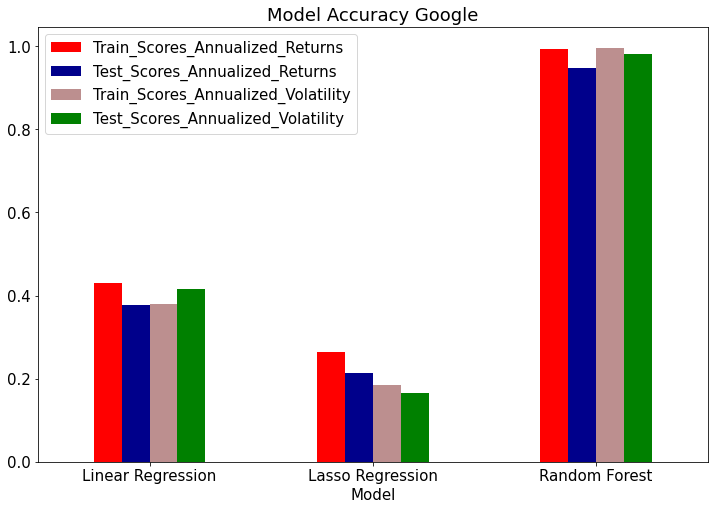

In [100]:
get_model_accuracy_results(df_googl, "red" , "darkblue" , "rosybrown", "green" , "Model Accuracy Google");

It is clear that the random forest method produces more accurate results that both the Linear Regression and Lasso Regression. Therefore, we will use the predicted annualized returns and annualized volatility from the Random forest technique in order to construct the optimal portfolio in the following section of the project.

## Optimal Portfolio

### Start with portfolio optimization of only stocks

Take the results from the Random forest method for both the Predicted Annual Returns and Annual Volatilites of stocks

In [101]:
Predicted_Future_Annualized_Returns = [list(Apple_returns[2].values())[6],
                                       list(Microsoft_returns[2].values())[6],
                                       list(Walmart_returns[2].values())[6],
                                      list(Amazon_returns[2].values())[6],
                                      list(Facebook_returns[2].values())[6],
                                       list(Google_returns[2].values())[6]]
Predicted_Future_Annualized_Returns

[0.8569, 0.4409, 0.2836, 0.7876, 0.4013, 0.3654]

In [102]:
Predicted_Future_Annualized_Volatility = [list(Apple_volatility[2].values())[6],
                                       list(Microsoft_volatility[2].values())[6],
                                       list(Walmart_volatility[2].values())[6],
                                      list(Amazon_volatility[2].values())[6],
                                      list(Facebook_volatility[2].values())[6],
                                      list(Google_volatility[2].values())[6]]
Predicted_Future_Annualized_Volatility

[0.2943, 0.1109, 0.0586, 0.2881, 0.1911, 0.1275]

Create a function that simulates 10000 portfolios with different weights that sum to one and returns the portfolio returns, portfolio volatility, portfolio Sharpe ratio and the corresponding weights to each stock.

In [114]:
def portfolio_optimization(simulations, annual_returns, annual_volatility, risk_free_rate ):
    
    weights = []
    
    for i in range(simulations):
        
        a = np.random.dirichlet(np.ones((6)),size=1).round(2)
        
        weights.append(a)
        
        ret = weights@np.array(annual_returns)
        
        vol = weights@np.array(annual_volatility)
        
        sharp = (ret - risk_free_rate) / vol
        
        portfolio_returns = [i for j  in ret.tolist() for i in j]
        
        portfolio_volatility = [i for j  in vol.tolist() for i in j]
        
        portfolio_sharpe_ratio = [i for j  in sharp.tolist() for i in j]

        
    return [portfolio_returns , portfolio_volatility , portfolio_sharpe_ratio, weights ]


Simulate the 10000 random portfolios and create 3 lists: The first one give the weights that correspond to the portfolio with the minimum annual volatility, the second to the maximum return, and the third to the maximum Sharpe ratio. 

In [115]:
random_port = portfolio_optimization(10000, Predicted_Future_Annualized_Returns, Predicted_Future_Annualized_Volatility, 0.01 )

portfolio_data = {'Portfolio Returns': random_port[0] ,
                    'Portfolio Volatility': random_port[1] ,
                    'Portfolio Sharpe Ratio': random_port[2] ,
                    'Weights': random_port[3] }

portfolio_df = pd.DataFrame(portfolio_data,
                            columns = ['Portfolio Returns','Portfolio Volatility','Portfolio Sharpe Ratio', 'Weights' ],)

min_volatility_portfolio_allocation = [i for j in 
        portfolio_df.sort_values('Portfolio Volatility').head().iloc[0]["Weights"].tolist() for i in j ]

max_annual_return_portfolio_allocation = [i for j in 
        portfolio_df.sort_values('Portfolio Returns').tail().iloc[4]["Weights"].tolist() for i in j ]

optimal_portfolio_allocation = [i for j in 
        portfolio_df.sort_values('Portfolio Sharpe Ratio').tail().iloc[4]["Weights"].tolist() for i in j ]



Print portfolios with the highest Sharpe ratios

In [116]:
portfolio_df.sort_values('Portfolio Sharpe Ratio').tail()

Portfolio Returns  Portfolio Volatility  Portfolio Sharpe Ratio  \
5966           0.383664              0.096158                3.885938   
2921           0.338706              0.083875                3.918999   
3167           0.358693              0.088972                3.919132   
3942           0.329878              0.080330                3.982049   
3850           0.347097              0.083283                4.047609   

                                     Weights  
5966   [[0.01, 0.54, 0.4, 0.01, 0.03, 0.01]]  
2921   [[0.01, 0.17, 0.7, 0.02, 0.02, 0.09]]  
3167   [[0.03, 0.33, 0.58, 0.0, 0.03, 0.03]]  
3942  [[0.06, 0.01, 0.86, 0.01, 0.01, 0.05]]  
3850   [[0.04, 0.24, 0.69, 0.0, 0.01, 0.02]]

Print portfolios with the highest annual returns

In [117]:
portfolio_df.sort_values('Portfolio Returns').tail()

Portfolio Returns  Portfolio Volatility  Portfolio Sharpe Ratio  \
3590           0.780559              0.266424                2.892228   
5851           0.782744              0.278101                2.778645   
7358           0.786371              0.271073                2.864066   
8694           0.790255              0.271929                2.869334   
9302           0.799285              0.275683                2.863017   

                                     Weights  
3590  [[0.81, 0.02, 0.07, 0.04, 0.02, 0.05]]  
5851   [[0.37, 0.04, 0.01, 0.55, 0.03, 0.0]]  
7358   [[0.7, 0.04, 0.03, 0.18, 0.01, 0.04]]  
8694   [[0.84, 0.03, 0.0, 0.03, 0.02, 0.07]]  
9302  [[0.73, 0.05, 0.01, 0.17, 0.01, 0.03]]

Print portfolios with the lowest annual volatility

In [118]:
portfolio_df.sort_values('Portfolio Volatility').head()

Portfolio Returns  Portfolio Volatility  Portfolio Sharpe Ratio  \
3942           0.329878              0.080330                3.982049   
4826           0.320936              0.081948                3.794309   
7732           0.327013              0.083179                3.811214   
3850           0.347097              0.083283                4.047609   
2921           0.338706              0.083875                3.918999   

                                     Weights  
3942  [[0.06, 0.01, 0.86, 0.01, 0.01, 0.05]]  
4826  [[0.02, 0.05, 0.73, 0.01, 0.03, 0.15]]  
7732  [[0.02, 0.06, 0.77, 0.02, 0.05, 0.08]]  
3850   [[0.04, 0.24, 0.69, 0.0, 0.01, 0.02]]  
2921   [[0.01, 0.17, 0.7, 0.02, 0.02, 0.09]]

Now let's create three pie plot that return the stock allocation depending on the preferences of the investor. (Max annual return, Min annual volatility, Optimal Allocation) There are some investors who want to minimize volatility and others who want to maximize returns. However, the overwhelming majority of investors wants to allocate their assets in order to maximize Sharpe ratio (Excess annual return / Annual Volatility). 

In [119]:
stocks = ['Apple','Microsoft','Walmart', 'Amazon', 'Facebook', 'Google']


fig = make_subplots(rows=2, cols=2, specs=[[{'type':'domain'}, {'type':'domain'}], [{'type':'domain'}, {'type':'domain'}]],
                   subplot_titles=("Maximum Annual Return Portfolio Allocation", 
                                   "Minimum Annual Volatility Portfolio Allocation", "Optimal Portfolio Allocation"))
fig.add_trace(go.Pie(labels=stocks, values= max_annual_return_portfolio_allocation, 
                     name="Maximum Annual Return Portfolio Allocation"), 1, 1)
fig.add_trace(go.Pie(labels=stocks, values= min_volatility_portfolio_allocation, 
                     name="Minimum Annual Volatility Portfolio Allocation"), 1, 2)
fig.add_trace(go.Pie(labels=stocks, values= optimal_portfolio_allocation, 
                     name="Optimal Portfolio Allocation"), 2, 1)

fig.update_layout(autosize=False, width=1000,height=800)


fig.show()


### Incorporate Bonds and Stocks in the optimal portfolio allocation

Since bond ETFs are less risky than stocks, we do not need to predict tomorrow's annual return and annual volatility. Hence, we will take the historical annual return and historical annual volatility given by the data frame. Then, we will replicate the portfolio simulation that we did for stocks and keep only the portfolio whose weights result in the maximum Sharpe ratio. Finally, depending on the risk aversion of the investor, we will change the percentages of the portfolios that will go towards stocks, and bond ETFs.

In [120]:
historical_annual_returns_bond_ETF = annualized_returns_bonds.iloc[-1].tolist()
historical_annual_volatility_bond_ETF = annualized_volatility_bonds.iloc[-1].tolist()

In [121]:
def portfolio_optimization_bonds(simulations, annual_returns, annual_volatility, risk_free_rate ):
    
    weights = []
    
    for i in range(simulations):
        
        a = np.random.dirichlet(np.ones((4)),size=1).round(2)
        
        weights.append(a)
        
        ret = weights@np.array(annual_returns)
        
        vol = weights@np.array(annual_volatility)
        
        sharp = (ret - risk_free_rate) / vol
        
        portfolio_returns = [i for j  in ret.tolist() for i in j]
        
        portfolio_volatility = [i for j  in vol.tolist() for i in j]
        
        portfolio_sharpe_ratio = [i for j  in sharp.tolist() for i in j]

        
    return [portfolio_returns , portfolio_volatility , portfolio_sharpe_ratio, weights ]


In [123]:
random_port_bond_ETF = portfolio_optimization_bonds(10000, historical_annual_returns_bond_ETF, 
                                              historical_annual_volatility_bond_ETF, 0.01 )

port_data_bonds = {'Portfolio Returns': random_port_bond_ETF[0] ,
                    'Portfolio Volatility': random_port_bond_ETF[1] ,
                    'Portfolio Sharpe Ratio': random_port_bond_ETF[2] ,
                    'Weights': random_port_bond_ETF[3] }

portfolio_df_bonds = pd.DataFrame(port_data_bonds,
                            columns = ['Portfolio Returns','Portfolio Volatility','Portfolio Sharpe Ratio', 'Weights' ],)

min_volatility_portfolio_allocation_bonds = [i for j in 
        portfolio_df_bonds.sort_values('Portfolio Volatility').head().iloc[0]["Weights"].tolist() for i in j ]

max_annual_return_portfolio_allocation_bonds = [i for j in 
        portfolio_df_bonds.sort_values('Portfolio Returns').tail().iloc[4]["Weights"].tolist() for i in j ]

optimal_portfolio_allocation_bonds = [i for j in 
        portfolio_df_bonds.sort_values('Portfolio Sharpe Ratio').tail().iloc[4]["Weights"].tolist() for i in j ]



In [124]:
Dynamic_Growth_Portfolio = ([i * 0.8 for i in optimal_portfolio_allocation] + 
                     [j * 0.2 for j in optimal_portfolio_allocation_bonds])
Balanced_Growth_Portfolio = ([i * 0.6 for i in optimal_portfolio_allocation] + 
                     [j * 0.4 for j in optimal_portfolio_allocation_bonds])
Balanced_Portfolio = ([i * 0.5 for i in optimal_portfolio_allocation] + 
                     [j * 0.5 for j in optimal_portfolio_allocation_bonds])
Conservative_Portfolio = ([i * 0.4 for i in optimal_portfolio_allocation] + 
                     [j * 0.6 for j in optimal_portfolio_allocation_bonds])
Defensive_Portfolio = ([i * 0.2 for i in optimal_portfolio_allocation] + 
                     [j * 0.8 for j in optimal_portfolio_allocation_bonds])

In [125]:
stocks = ['Apple','Microsoft','Walmart', 'Amazon', 'Facebook', 'Google']

bond_ETFS = ["BND" , "VCIT" , "VCSH" , "VBTLX" , "AGG"]

stocks_and_bonds = ['Apple','Microsoft','Walmart', 'Amazon', 'Facebook', 'Google',
                    "BND" , "VCIT" , "VCSH" , "VBTLX" , "AGG"]

fig = make_subplots( rows=3, cols=2, specs=[[{'type':'domain'}, {'type':'domain'}], [{'type':'domain'}, {'type':'domain'}],
                    [{'type':'domain'}, {'type':'domain'}]] ,
                   subplot_titles=("All Equity Portfolio", "Dynamic Growth Portfolio (80% stocks 20% bond ETF)", 
                "Balanced Growth Portfolio (60% stocks 40% bond ETF)" , "Balanced Portfolio (50% stocks 50% bond ETF)",
                "Conservative Portfolio (40% stocks 60% bond ETF)", "Defensive Portfolio (20% stocks 80% bond ETF)"))
fig.add_trace(go.Pie(labels=stocks, values= optimal_portfolio_allocation, 
                     name="All Equity Portfolio"), 1, 1)
fig.add_trace(go.Pie(labels=stocks_and_bonds, values= Dynamic_Growth_Portfolio, 
                     name="Dynamic Growth Portfolio"), 1, 2)
fig.add_trace(go.Pie(labels=stocks_and_bonds, values= Balanced_Growth_Portfolio, 
                     name="Balanced Growth Portfolio"), 2, 1)
fig.add_trace(go.Pie(labels=stocks_and_bonds, values= Balanced_Portfolio, 
                     name="Balanced Portfolio"), 2, 2)
fig.add_trace(go.Pie(labels=stocks_and_bonds, values= Conservative_Portfolio, 
                     name="Conservative Portfolio"), 3, 1)
fig.add_trace(go.Pie(labels=stocks_and_bonds, values= Defensive_Portfolio, 
                     name="Defensive Portfolio"), 3, 2)


fig.update_layout(autosize=False, width=1000,height=1300)


fig.show()


### Potential Problems:

One potential problem of the model is that since we do not have access to proprietary data, we do not have the real daily changes of the fundamental indicators. Instead, we created daily approximations for the values in between quarters to make a data frame that updates on a daily basis. 

Another problem, which also arises from the fact that we use only free data, is that it takes a lot of time to collect the data from the various sources. Hence, it very time consuming to load and create the final format of the data frames.

### Further Improvements

Expand the model to predict further into the future; not only tomorrow's annual return and annual volatility.

Incorporate other assets such as commodities, mutual funds, cryptocurrencies, REITS in order to achieve greater diversification of the optimal portfolio.